# Dataframe Prep, Random Forest Modeling and Evaluation

-This notebook reads in the df_gen, df_slope, and df_ruby notebooks from Processing

-The filtering gets a little complicated here, heavy annotations for clarity. I'm creating both a RF for progeny (first here), then mothers. 

-Output should be shap files, accuracy predicitions, and pred vs actual correlation plots. 

In [2]:
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import shap
import matplotlib.cm as cm

# makes figures look better in Jupyter
sns.set_context('talk')
sns.set_style("ticks")
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

['/Volumes/salmonella/users/madison/2024_DIMM_MultirepAnalysis/LineagePlotting', '/Users/Madison/opt/anaconda3/envs/gmm/lib/python3.12/site-packages/cv2', '/Users/Madison/opt/anaconda3/envs/gmm/lib/python312.zip', '/Users/Madison/opt/anaconda3/envs/gmm/lib/python3.12', '/Users/Madison/opt/anaconda3/envs/gmm/lib/python3.12/lib-dynload', '', '/Users/Madison/opt/anaconda3/envs/gmm/lib/python3.12/site-packages', '__editable__.pyTrackMateXML-1.0.0.finder.__path_hook__']


## Filtering and Merging Dataframes

In [3]:
plot_output = '/Volumes/salmonella/users/madison/2024_DIMM_MultirepAnalysis/LineagePlotting/Final_Plots'
df_gen = pd.read_csv(os.path.join(plot_output, 'df_gen.csv'))
df_slope = pd.read_csv(os.path.join(plot_output, 'slope_df_final.csv'))
df_ruby = pd.read_csv(os.path.join(plot_output, 'ruby_features_final.csv'))

In [4]:
#Filtering incomplete cycles
df_gen_no_end_cycle = df_gen[df_gen['end_time']!=1080] #removes incomplete cycles at the end of the expt

#Now remove cycles where cells fall out end of channel - defined as cycles that both don't have a following cycle and don't have valid cell IDs through the last time point
df_gen_no_end_cycle = df_gen_no_end_cycle.sort_values(by=['unique_ID', 'cell_id', 'cycle']) #sort
df_gen_no_end_cycle['next_cycle'] = df_gen_no_end_cycle.groupby(['unique_ID','cell_id'])['cycle'].shift(-1) #find following cycle
df_gen_no_lost_cells = df_gen_no_end_cycle[(df_gen_no_end_cycle['next_cycle'] == df_gen_no_end_cycle['cycle'] + 1) | (df_gen_no_end_cycle['last_valid_cell_time'] == 1080)].copy() #filter

#Remove first cycle as that's also incomplete
df_gen_filtered = df_gen_no_lost_cells[df_gen_no_lost_cells['start_time']!=0]

print(len(df_gen))
print(len(df_gen_no_end_cycle))
print(len(df_gen_no_lost_cells))
print(len(df_gen_filtered))
columns_with_nan = df_gen_filtered.isna().sum()
columns_with_nan = columns_with_nan[columns_with_nan > 0]
print(columns_with_nan)
#rows_with_nan = df_gen_filtered[df_gen_filtered.isnull().any(axis=1)]
#print(rows_with_nan)

10222
6112
4983
4727
end_length           1
total_growth         1
avg_elong_rate       1
next_cycle        2117
dtype: int64


In [5]:
#Merging into all stats dataframe
gen_slope = df_gen_filtered.merge(df_slope, on=['unique_ID', 'cell_id'], how='left', suffixes=('_gen','_slope'))
all_stats = gen_slope.merge(df_ruby, on=['unique_ID', 'cell_id'], how='left', suffixes=('_genslope','_ruby'))
all_stats = all_stats[all_stats['category'] == 'switch']
#Adding a boolean for if the cycle is the one where the response happens
all_stats['response_cycle'] = (all_stats['start_time']<=all_stats['start_inc']) & (all_stats['start_inc']<all_stats['end_time'])
all_stats['start_inc'] = all_stats['start_inc'].astype(float)
all_stats['end_inc'] = all_stats['end_inc'].astype(float)
all_stats['gfp_on'] = all_stats['gfp_on'].astype(float)
all_stats.to_csv(plot_output +'all_stats_20250627.csv')

In [6]:
print(len(df_gen_filtered))
print(len(gen_slope))
print(len(all_stats))
all_stats.columns
columns_with_nan = all_stats.isna().sum()
columns_with_nan = columns_with_nan[columns_with_nan > 0]
print(columns_with_nan)

4727
4727
2185
next_cycle          725
parent_start_inc    692
dtype: int64


In [7]:
#Looking up the first cycle duration and appending to the table (note this has to be found on the unfiltered df_gen)
#Getting the duration of that first cycle (ie where in cell cycle was the og mother before the transition)
#should be one value per unique ID
first_cycle_lookup = (
    df_gen[(df_gen['parent'] == 0) & (df_gen['cycle'] == 0)] # ensure only one per unique_ID
    .set_index('unique_ID')['cycle_duration']
)

all_stats['initial_cycle_duration'] = all_stats['unique_ID'].map(first_cycle_lookup)

In [8]:
#Split into mothers and daughters dfs
all_stats_mothers = all_stats[all_stats['cell_id']==1]
all_stats_prog = all_stats[all_stats['cell_id']!=1]

In [9]:
#Retain only needed columns for mothers
cols_to_keep_mothers = ['unique_ID', 'channel_width', 'experiment_gen', 'cell_id', 'cycle', 
                'category', 'cycle_duration', 'start_length', 'mean_ruby_lifetime', 
                'initial_cycle_duration', 'time_of_min_slope_ruby', 'max_ruby', 
                'max_ruby_time', 'end_length', 'avg_elong_rate', 'total_growth', 
                'start_inc', 'min_slope_ruby', 'response_cycle']
all_stats_mothers_rc = all_stats_mothers[cols_to_keep_mothers]
all_stats_mothers_rc
columns_with_nan = all_stats_mothers_rc.isna().sum()
columns_with_nan = columns_with_nan[columns_with_nan > 0]
print(columns_with_nan)

Series([], dtype: int64)


In [10]:
cols_to_keep_prog = ['unique_ID', 'channel_width', 'experiment_gen', 'cell_id', 'cycle', 
                'category', 'cycle_duration', 'start_length', 'mean_ruby_lifetime', 
                'initial_cycle_duration', 'time_of_min_slope_ruby', 'max_ruby', 
                'max_ruby_time', 'end_length', 'avg_elong_rate', 'total_growth', 
                'start_inc', 'parent_start_inc', 'y_pos_start_inc', 'y_pos_appearance', 
               'min_slope_ruby', 'response_cycle']
all_stats_prog_rc = all_stats_prog[cols_to_keep_prog]
all_stats_prog_rc

,unique_ID,channel_width,experiment_gen,cell_id,cycle,category,cycle_duration,start_length,mean_ruby_lifetime,initial_cycle_duration,...,max_ruby_time,end_length,avg_elong_rate,total_growth,start_inc,parent_start_inc,y_pos_start_inc,y_pos_appearance,min_slope_ruby,response_cycle
6,20240809__XY02_crop2__Track_20,1.3,20240809,2,0,switch,465,1.482228,8.464784,535,...,540.0,4.687216,0.006892,3.204988,550.0,550.0,35.689655,35.672413,-0.045544,True
9,20240809__XY02_crop3__Track_8,1.3,20240809,2,0,switch,250,1.482228,8.870182,355,...,1080.0,3.034881,0.006211,1.552653,390.0,385.0,36.000000,33.900000,-0.046889,True
21,20240809__XY03_crop2__Track_0,1.3,20240809,2,0,switch,190,1.400143,9.144921,225,...,230.0,2.612967,0.006383,1.212825,240.0,240.0,38.095238,36.516130,-0.056960,True
22,20240809__XY03_crop2__Track_0,1.3,20240809,2,1,switch,325,1.453444,9.144921,225,...,230.0,3.314363,0.005726,1.860918,240.0,240.0,38.095238,36.516130,-0.056960,False
31,20240809__XY04_crop1__Track_14,1.3,20240809,2,0,switch,170,2.018143,8.923444,220,...,235.0,3.260383,0.007307,1.242241,325.0,330.0,49.027780,41.833332,-0.041630,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715,20241028__XY29_crop6__Track_3,1.2,20241028,6,1,switch,225,1.768191,8.812297,285,...,500.0,3.291337,0.006770,1.523146,630.0,630.0,54.329544,53.055046,-0.039643,True
4717,20241028__XY29_crop6__Track_3,1.2,20241028,8,0,switch,245,1.453444,8.625902,285,...,630.0,3.015327,0.006375,1.561883,710.0,780.0,190.207320,154.400000,-0.040268,True
4718,20241028__XY29_crop6__Track_3,1.2,20241028,9,0,switch,230,1.521611,8.749192,285,...,835.0,3.144280,0.007055,1.622670,740.0,680.0,148.674420,117.639340,-0.033366,True
4719,20241028__XY29_crop6__Track_3,1.2,20241028,10,0,switch,210,1.453444,8.915859,285,...,775.0,2.779082,0.006313,1.325638,835.0,965.0,147.720340,96.357140,-0.028858,True


In [11]:
#get numbers out of arrays in case any weirdness happened with merges
def unwrap_scalar_array(x):
    if isinstance(x, np.ndarray) and x.size == 1:
        return x.item()
    return x
for column in all_stats_mothers_rc:
    all_stats_mothers_rc[column] = all_stats_mothers_rc[column].apply(unwrap_scalar_array)
for column in all_stats_prog_rc:
    all_stats_prog_rc[column] = all_stats_prog_rc[column].apply(unwrap_scalar_array)

/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_30722/4259426855.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_stats_mothers_rc[column] = all_stats_mothers_rc[column].apply(unwrap_scalar_array)
/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_30722/4259426855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_stats_prog_rc[column] = all_stats_prog_rc[column].apply(unwrap_scalar_array)


In [12]:
#Now find variables that are on a per cycle basis and get the averages of them, retain ones that are the same for every cycle
#should have 1 row per cell now
for col in all_stats_mothers_rc.columns:
    unhashable = all_stats_mothers_rc[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any()
    if unhashable:
        print(f"Column '{col}' contains unhashable types like list or ndarray.")

grouped = all_stats_mothers_rc.groupby(['unique_ID', 'cell_id'])

# Identify constant variables (same value across all cycles in each group)
constant_vars = []
for col in all_stats_mothers_rc.columns:
    if col not in ['unique_ID', 'cell_id', 'cycle']:
        nunique_per_group = grouped[col].nunique()
        if nunique_per_group.max() == 1:
            constant_vars.append(col)
print("constant variables, keeping one:",constant_vars)

# Identify varying variables (change across cycles)
varying_vars = [col for col in all_stats_mothers_rc.columns
                if col not in ['unique_ID', 'cell_id', 'cycle']
                and col not in constant_vars]
print("cycle based variables, averaging:",varying_vars)

# Aggregate
constant_df = grouped[constant_vars].first().reset_index()
varying_df = grouped[varying_vars].mean().reset_index()

# Rename varying columns
varying_df = varying_df.rename(columns={col: f"{col}_avg" for col in varying_vars})

# Merge
avg_stats_mothers = pd.merge(constant_df, varying_df, on=['unique_ID', 'cell_id'])
avg_stats_mothers = avg_stats_mothers.drop('response_cycle_avg', axis=1)
columns_with_nan = avg_stats_mothers.isna().sum()
columns_with_nan = columns_with_nan[columns_with_nan > 0]
print(columns_with_nan)

constant variables, keeping one: ['channel_width', 'experiment_gen', 'category', 'mean_ruby_lifetime', 'initial_cycle_duration', 'time_of_min_slope_ruby', 'max_ruby', 'max_ruby_time', 'start_inc', 'min_slope_ruby']
cycle based variables, averaging: ['cycle_duration', 'start_length', 'end_length', 'avg_elong_rate', 'total_growth', 'response_cycle']
Series([], dtype: int64)


In [13]:
#Now find variables that are on a per cycle basis and get the averages of them, retain ones that are the same for every cycle
#should have 1 row per cell now
for col in all_stats_prog_rc.columns:
    unhashable = all_stats_prog_rc[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any()
    if unhashable:
        print(f"Column '{col}' contains unhashable types like list or ndarray.")

grouped = all_stats_prog_rc.groupby(['unique_ID', 'cell_id'])

# Identify constant variables (same value across all cycles in each group)
constant_vars = []
for col in all_stats_prog_rc.columns:
    if col not in ['unique_ID', 'cell_id', 'cycle']:
        nunique_per_group = grouped[col].nunique()
        if nunique_per_group.max() == 1:
            constant_vars.append(col)
print("constant variables, keeping one:",constant_vars)

# Identify varying variables (change across cycles)
varying_vars = [col for col in all_stats_prog_rc.columns
                if col not in ['unique_ID', 'cell_id', 'cycle']
                and col not in constant_vars]
print("cycle based variables, averaging:",varying_vars)

# Aggregate
constant_df = grouped[constant_vars].first().reset_index()
varying_df = grouped[varying_vars].mean().reset_index()

# Rename varying columns
varying_df = varying_df.rename(columns={col: f"{col}_avg" for col in varying_vars})

# Merge
avg_stats_prog = pd.merge(constant_df, varying_df, on=['unique_ID', 'cell_id'])
avg_stats_prog = avg_stats_prog.drop('response_cycle_avg', axis=1)

constant variables, keeping one: ['channel_width', 'experiment_gen', 'category', 'mean_ruby_lifetime', 'initial_cycle_duration', 'time_of_min_slope_ruby', 'max_ruby', 'max_ruby_time', 'start_inc', 'parent_start_inc', 'y_pos_start_inc', 'y_pos_appearance', 'min_slope_ruby']
cycle based variables, averaging: ['cycle_duration', 'start_length', 'end_length', 'avg_elong_rate', 'total_growth', 'response_cycle']


In [14]:
#Now go back and get the response cycle only in a dataframe, then merge onto the averages. 
#we lose cells here that respond in the first or last incomplete cycles because they've already been filtered out of df_gen
res_cycle_mothers_df = all_stats_mothers[all_stats_mothers['response_cycle']==True]


res_cycle_prog_df = all_stats_prog[all_stats_prog['response_cycle']==True]
for column in res_cycle_mothers_df:
    res_cycle_mothers_df[column] = res_cycle_mothers_df[column].apply(unwrap_scalar_array)
for column in res_cycle_prog_df:
    res_cycle_prog_df[column] = res_cycle_prog_df[column].apply(unwrap_scalar_array)


##For this merge we're merging onto the res_cycle_df because it has fewer cells 
final_forest_df_mothers = pd.merge( res_cycle_mothers_df, avg_stats_mothers, on = ['cell_id', 'unique_ID'],  how='left')
print(len(final_forest_df_mothers))
final_forest_df_prog = pd.merge(res_cycle_prog_df, avg_stats_prog, on = ['cell_id', 'unique_ID'],  how='left')
print(len(final_forest_df_prog))

210
591


/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_30722/2001439899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_cycle_mothers_df[column] = res_cycle_mothers_df[column].apply(unwrap_scalar_array)
/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_30722/2001439899.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_cycle_prog_df[column] = res_cycle_prog_df[column].apply(unwrap_scalar_array)


## Random Forest Regressor and Evaluation - Mother Cells
Steps:

1. Define train and test data

2. Remove any extraneous columns

3. Define input and output columns

4. Random Forest Regressor

5. SHAP values and prediction accuracy

In [15]:
cols_to_keep = ['unique_ID', 'channel_width_x', 'experiment_gen_x',
        'mean_ruby_lifetime_x', 'initial_cycle_duration_x',
        'max_ruby_x',  'max_ruby_time_x', 
       'start_inc_x', 'time_of_min_slope_ruby_x',
       'cycle_duration_avg', 'start_length_avg', 'end_length_avg',
       'avg_elong_rate_avg', 'total_growth_avg', 
        'cycle', 'cycle_duration', 'start_length',
       'end_length', 'avg_elong_rate', 'total_growth', 
       ]
final_forest_df_clean_mothers = final_forest_df_mothers[cols_to_keep]
#There should be no NaNs at this point, if there are you need to drop the cell or lose the parameter

In [48]:
train,test=train_test_split(final_forest_df_clean_mothers, test_size=0.3, random_state=0)
train = train.drop(['unique_ID'], axis=1)
test = test.drop(['unique_ID'], axis=1)
#train = train.drop(['cell_id'], axis=1)
#test = test.drop(['cell_id'], axis=1)
train = train.drop(['cycle'], axis=1)
test = test.drop(['cycle'], axis=1)

# Create X_train,Y_train,X_test
X_train = train.drop(['start_inc_x'], axis=1)
Y_train = train['start_inc_x']

X_test  = test.drop(['start_inc_x'], axis=1)
Y_test  = test['start_inc_x']
print(len(X_train))
print(len(X

In [49]:
# Random Forest
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_preds = random_forest.predict(X_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example metrics
print("Mean Squared Error:", mean_squared_error(Y_test, random_forest_preds))
print("Mean Absolute Error:", mean_absolute_error(Y_test, random_forest_preds))
print("R^2 Score:", r2_score(Y_test, random_forest_preds))

Mean Squared Error: 12992.930357142855
Mean Absolute Error: 89.50873015873015
R^2 Score: 0.35444048058681155


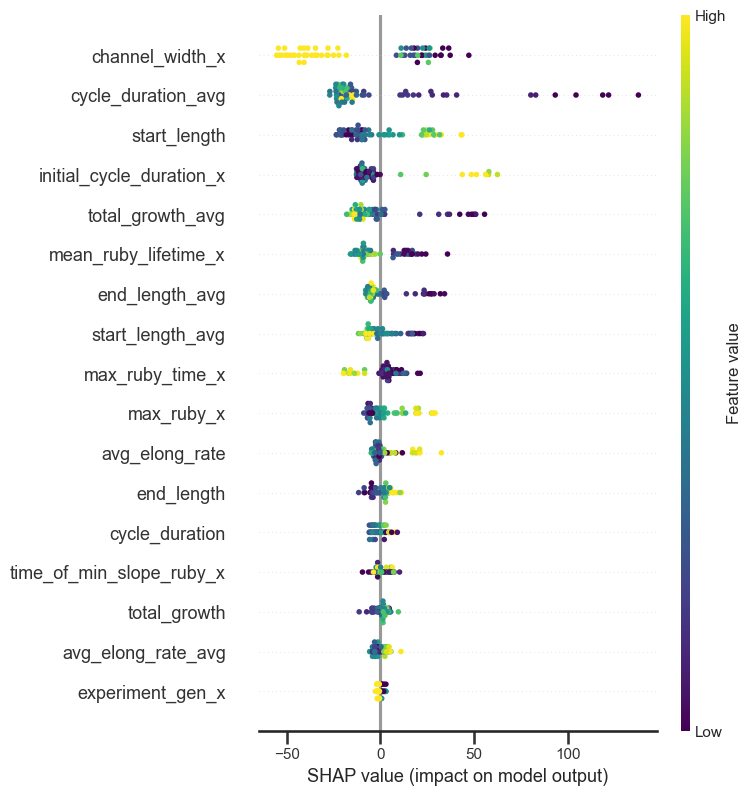

In [52]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer(X_test)
n_features = X_test.shape[1]
cmap = plt.colormaps["viridis"].resampled(n_features)
color_list = [cmap(i) for i in range(n_features)]
shap.summary_plot(shap_values, X_test, cmap='viridis', show=False)

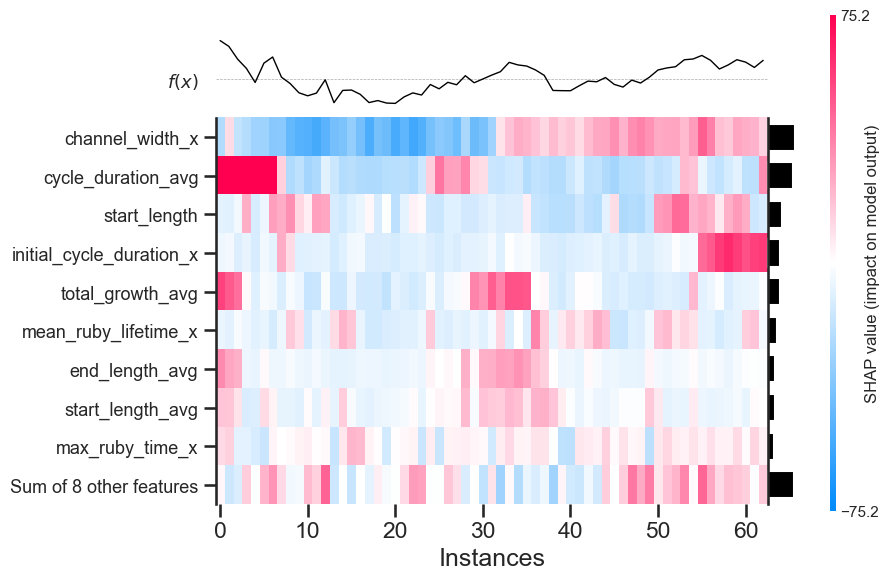

<Axes: xlabel='Instances'>

In [53]:
shap.plots.heatmap(shap_values)

(100.0, 850.0)

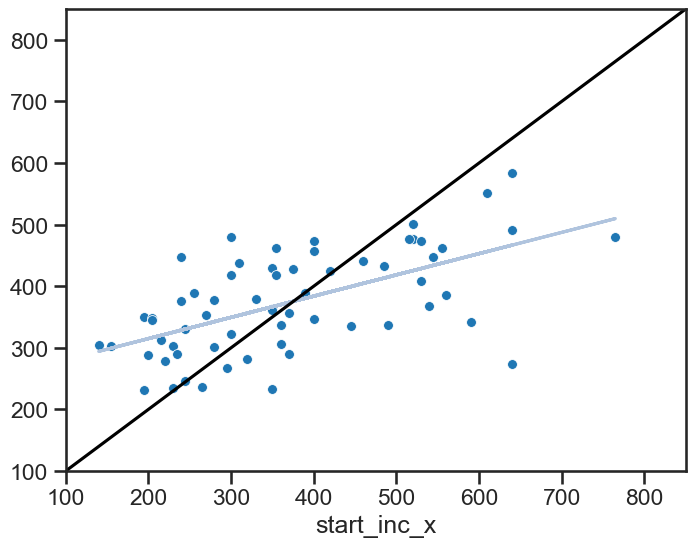

In [55]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=random_forest_preds, s=50, edgecolor="white")
z = np.polyfit(Y_test, random_forest_preds, 1)  # Linear trendline (degree 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "lightsteelblue")
x = np.array([100, 850])
y = 1 * x + 0
plt.plot(x, y, "black")

# Set the x and y axis limits to make the line visible
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.ylim(100, 850)
plt.xlim(100,850)


In [57]:
accuracy_df_mothers = pd.DataFrame({'Experimental': Y_test, 'Predicted': random_forest_preds})
accuracy_df_mothers['individual_acc']= abs((accuracy_df_mothers['Predicted']-accuracy_df_mothers['Experimental'])/accuracy_df_mothers['Experimental'])
accuracy = 1-(1/len(accuracy_df_mothers) * accuracy_df_mothers['individual_acc'].sum()) 
print(accuracy_df_mothers['individual_acc'].mean())
print(accuracy_df_mothers['individual_acc'].std())
print(accuracy)
accuracy_df

0.27639682902090845
0.24854258190013934
0.7236031709790915


,Experimental,Predicted,individual_acc
12,280.0,302.15,0.079107
80,640.0,583.95,0.087578
33,350.0,430.10,0.228857
5,155.0,302.60,0.952258
188,400.0,472.95,0.182375
...,...,...,...
129,400.0,347.00,0.132500
110,200.0,288.90,0.444500
206,460.0,440.85,0.041630
107,300.0,479.50,0.598333


## Random Forest and Evaluation - Progeny


In [72]:
cols_to_keep = ['unique_ID', 'channel_width_x', 'experiment_gen_x',
        'mean_ruby_lifetime_x', 'initial_cycle_duration_x',
        'max_ruby_x',  
       'start_inc_x',  
       'cycle_duration_avg', 'start_length_avg', 'end_length_avg',
       'avg_elong_rate_avg', 'total_growth_avg', 
        'cycle', 'cycle_duration', 'start_length',
       'end_length', 'avg_elong_rate', 'total_growth', 
       ]
final_forest_df_clean_prog = final_forest_df_prog[cols_to_keep]
final_forest_df_clean_prog = final_forest_df_clean_prog.dropna() 
final_forest_df_clean_prog.columns

Index(['unique_ID', 'channel_width_x', 'experiment_gen_x',
       'mean_ruby_lifetime_x', 'initial_cycle_duration_x', 'max_ruby_x',
       'start_inc_x', 'cycle_duration_avg', 'start_length_avg',
       'end_length_avg', 'avg_elong_rate_avg', 'total_growth_avg', 'cycle',
       'cycle_duration', 'start_length', 'end_length', 'avg_elong_rate',
       'total_growth'],
      dtype='object')

In [73]:
train,test=train_test_split(final_forest_df_clean_prog, test_size=0.3, random_state=0)
train = train.drop(['unique_ID'], axis=1)
test = test.drop(['unique_ID'], axis=1)
#train = train.drop(['cell_id'], axis=1)
#test = test.drop(['cell_id'], axis=1)
train = train.drop(['cycle'], axis=1)
test = test.drop(['cycle'], axis=1)

# Create X_train,Y_train,X_test
X_train = train.drop(['start_inc_x'], axis=1)
Y_train = train['start_inc_x']

X_test  = test.drop(['start_inc_x'], axis=1)
Y_test  = test['start_inc_x']

In [74]:
# Random Forest
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_preds = random_forest.predict(X_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example metrics
print("Mean Squared Error:", mean_squared_error(Y_test, random_forest_preds))
print("Mean Absolute Error:", mean_absolute_error(Y_test, random_forest_preds))
print("R^2 Score:", r2_score(Y_test, random_forest_preds))

Mean Squared Error: 13956.260308988763
Mean Absolute Error: 90.84044943820226
R^2 Score: 0.37248942497315685


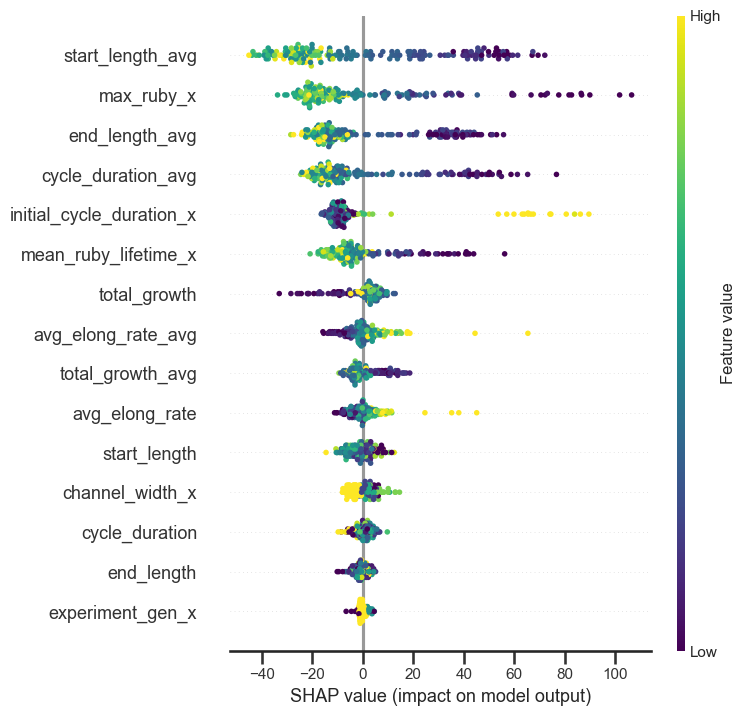

In [75]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer(X_test)
n_features = X_test.shape[1]
cmap = plt.colormaps["viridis"].resampled(n_features)
color_list = [cmap(i) for i in range(n_features)]
shap.summary_plot(shap_values, X_test, cmap='viridis', show=False)
plt.savefig(plot_output +'/progeny_shap_plot.pdf',bbox_inches='tight', transparent=True)

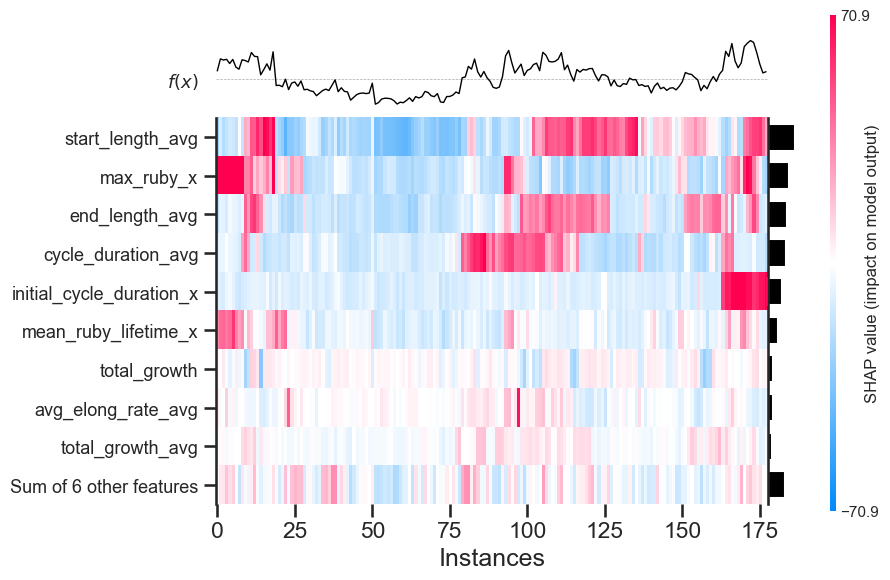

<Figure size 640x480 with 0 Axes>

In [76]:
shap.plots.heatmap(shap_values)
plt.savefig(plot_output +'/progeny_shap_heatmap.pdf',bbox_inches='tight', transparent=True)

178

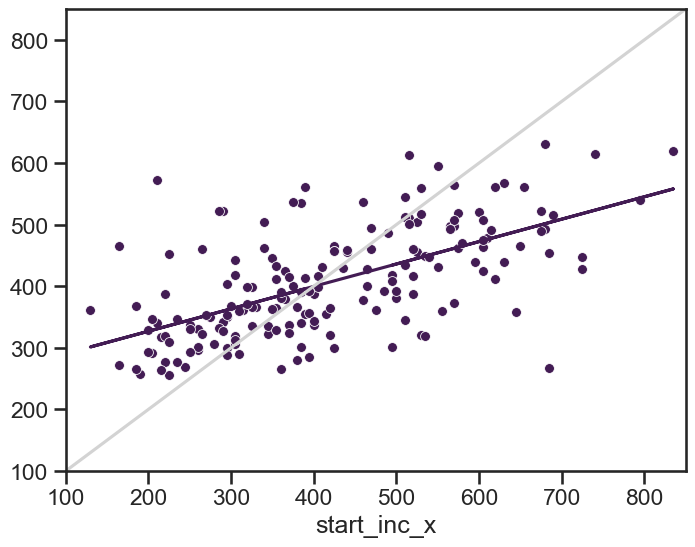

In [81]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=random_forest_preds, s=50, color = "#431c54", edgecolor="white")
z = np.polyfit(Y_test, random_forest_preds, 1)  # Linear trendline (degree 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "#431c54")
x = np.array([100, 850])
y = 1 * x + 0
plt.plot(x, y, "lightgrey")

# Set the x and y axis limits to make the line visible
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.ylim(100, 850)
plt.xlim(100,850)
plt.savefig(plot_output +'/progeny_expvspred.pdf',bbox_inches='tight', transparent=True)
#len(random_forest_preds)
len(Y_test)

In [83]:
accuracy_df_prog = pd.DataFrame({'Experimental': Y_test, 'Predicted': random_forest_preds})
accuracy_df_prog['individual_acc']= abs((accuracy_df_prog['Predicted']-accuracy_df_prog['Experimental'])/accuracy_df_prog['Experimental'])
accuracy = 1-(1/len(accuracy_df_prog) * accuracy_df_prog['individual_acc'].sum()) 
print(accuracy_df_prog['individual_acc'].mean())
print(accuracy_df_prog['individual_acc'].std())
print(accuracy)
accuracy_df_prog

0.24762655862831448
0.27484361523253054
0.7523734413716856


,Experimental,Predicted,individual_acc
225,390.0,355.15,0.089359
14,380.0,279.90,0.263421
85,565.0,498.45,0.117788
418,355.0,364.90,0.027887
132,500.0,380.75,0.238500
...,...,...,...
369,225.0,309.75,0.376667
140,465.0,400.90,0.137849
534,485.0,391.75,0.192268
171,510.0,344.55,0.324412


In [ ]:
len(accuracy_df